In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.envs.darkroom import DarkroomEnv

from copy import copy

import networkx as nx


# Load Model

In [10]:
query_type = 'far'

In [11]:
corr = 0.25
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "darkroom_simple")

epoch=13-val_loss=0.911523.ckpt


In [12]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))
maze_dim = int(re.search(r'_dim(\d+)_corr', eval_dset_path).group(1))
node_encoding_corr = float(re.search(r'corr(\d*\.?\d*)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": state_dim,
    "action_dim": 5,
    "dropout": dropout,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
}

In [13]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

/tmp/ipykernel_2190588/4170590101.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [14]:
n_eval_envs = 50

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()


# Helper Functions

In [15]:
def run_model_and_get_attentions(traj, model, env, seq_length):
    hidden_states = [[] for _ in range(model.n_layer)]
    batch = {
        'context_states': convert_to_tensor([np.array(traj['context_states'])]),
        'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
        'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
        'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
        'query_states': convert_to_tensor([np.array(traj['query_state'])]),
        }
    batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
    for k in batch.keys():
        if 'context' in k:
            batch[k] = batch[k][:,:seq_length]
        batch[k] = batch[k].to(model.device)
    model.save_activations = True
    with torch.no_grad():
        out = model(batch)
    _hidden_states = model.activations['hidden_states'][1:] # Tuple over layers
    for i_layer in range(model.n_layer):
        hidden_states[i_layer].append(_hidden_states[i_layer])
    return model.activations['attentions']

# Attention 

In [16]:
def get_results():

    results = {
        'attn': [],
        'distance': [],
        'layer': []
    }
    
    for i_eval in range(len(eval_trajs)):
        traj = eval_trajs[i_eval]
        env_config = {
            'maze_dim': maze_dim,
            'horizon': 200,
            'state_dim': state_dim,
            'node_encoding_corr': node_encoding_corr,
            'initialization_seed': np.array(traj['initialization_seed']).item(),
            'goal': np.array(traj['goal'])
        }
        env = DarkroomEnv(**env_config)
        optimal_action_map, dist_from_goal = env.make_opt_action_dict()
        valid_query_states = []
        for i in range(len(traj['context_states'])):
            d = dist_from_goal[tuple(traj['context_states'][i].tolist())]
            if query_type == 'far' and d < 7:
                continue
            elif query_type == 'middle' and d != 5:
               continue
            valid_query_states.append(traj['context_states'][i])
        if len(valid_query_states) == 0:
            continue
        else:
            traj['query_state'] = valid_query_states[np.random.choice(len(valid_query_states))]
        
        context_length = 200
        states = []
        next_states = []
        
        state_features = traj['context_states'].squeeze()
        next_state_features = traj['context_next_states'].squeeze()
        for state_feature, next_state_feature in zip(state_features, next_state_features):
            state_feature = tuple(state_feature.tolist())
            next_state_feature = tuple(next_state_feature.tolist())
            states.append(list(env.node_map_encoding_to_pos[state_feature]))
            next_states.append(list(env.node_map_encoding_to_pos[next_state_feature]))
            
        states = np.array(states)
        next_states = np.array(next_states)
        avg_state = (states + next_states) / 2
        saved_attentions = run_model_and_get_attentions(traj, model, env, context_length)

        for layer in range(model.n_layer):
            attns = saved_attentions[layer][0]
            attns = attns.mean(axis=0)
            attns = attns.detach().cpu().numpy()
    
            for idx_i in range(attns.shape[0]-1):
                for idx_j in range(idx_i):
                    attn = attns[idx_i, idx_j]
                    dist = np.linalg.norm(avg_state[idx_i] - avg_state[idx_j])
                    results['attn'].append(attn)
                    results['distance'].append(dist)
                    results['layer'].append(layer)
    return results

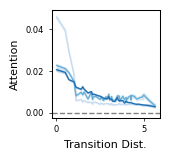

In [30]:
#results = get_results()
fig, ax = plt.subplots(figsize=(1.8, 1.7))
df = pd.DataFrame(results)
custom_palette = sns.color_palette("Blues", 3)
sns.lineplot(
    x='distance', y='attn',
    hue='layer',
    data=df, ax=ax, palette=custom_palette,
    legend=False
    )
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Transition Dist.', fontsize=8)
plt.ylabel('Attention', fontsize=8)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
for spine in ax.spines.values():
    spine.set_linewidth(0.75)
plt.tight_layout()
plt.savefig('figs/6e.png', dpi=300, transparent=True)
plt.savefig('figs/6e.pdf', dpi=300, transparent=True)
plt.show()